In [ ]:
import warnings

import numpy as np
warnings.simplefilter(action='ignore')

import pandas as pd
import seaborn as sns
import missingno as msno
from missingpy import MissForest
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, plot_importance

sns.set(rc={'figure.figsize':(10, 8)})

In [ ]:
df = pd.read_csv('train_music.csv', sep =',')
df

In [ ]:
df.info();

In [ ]:
df = df.sample(n = 20000, random_state=42)
df

In [ ]:
df.info()

In [ ]:
df.describe(include='all').T

In [ ]:
s = df.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df.isna().mean() * 100.0

nan.T

Ситуация с null ужасна, перед тем как делать окончательные выводы, посмотрим что у нас с балансом.

In [ ]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")

pd.DataFrame(
    {'count': [df['target'].isin([0]).sum(),
               df['target'].isin([1]).sum()]},
    index=['Will not download','Will download']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=ax)

plt.show()

На первый взгляд всё плохо. Огромное количество пропущенных данных и плохой баланс.
Очевидно, что семантику данных восстановить не получится, поскольку это данные пользователей и они как-то обработаны.
Прийдется работать с тем, что есть.

Итого:

    1) Слишком много NaN.
    РЕШЕНИЕ: Заполним пропущенные значения с самым выгодным условими для каждого признака.

    2) Слишком большое количество признаков, что не используется.
    РЕШЕНИЕ: Прийдется уменьшить количество признаков и выделить только самые нужные. Воспользуемся методом для нахождения тех признаков, что влияют на результат и уже будем проводить анализ и работать с этими признаками. (Feature Selection)

    3) Imbalance class.
    РЕШЕНИЕ: Воспользеумся методом Undersampling для уравнения классов. В качестве метрики будем использовать F1.

Для анализа пропущенных значений я попробую использовать - missingo.
Он позволяет наглядно построить графики пропущенных значений.

Для заполнения пропусков значений воспользеумся - missingpy
Он позволяет заполнить NaN найлучшим способом для каждого признака

In [ ]:
msno.heatmap(df[:20], figsize=(50,30))

In [ ]:
# НЕ ЗАПУСКАЕМ ЭТО
# imputer = MissForest(random_state=42, n_estimators = 35,  oob_score = True, n_jobs= -1)
# df_KNNImputer = imputer.fit_transform(df)

Сохраняем изменения в таблицу и сохраняем саму таблицу, чтобы, в случае перезагрузки JupyterNotebook не пришлось использовать этот метод еще раз

In [ ]:
# НЕ ЗАПУСКАЕМ ЭТО
# df_ForestImputer = df_KNNImputer
# df_ForestImputer = pd.DataFrame(df_ForestImputer, columns = df.columns)
# df_ForestImputer.to_csv('Train_music_ForestImputer.csv', index=False)

In [ ]:
df_ForestImputer = pd.read_csv('Train_music_ForestImputer.csv')
df_ForestImputer

In [ ]:
df['device_type'] = df['device_type'].map(str)
df['manufacturer_category'] = df['manufacturer_category'].map(int)
df['os_category'] = df['os_category'].map(str)

In [ ]:
df['device_type'].value_counts()

In [ ]:
df['manufacturer_category'].value_counts()

In [ ]:
df['os_category'].value_counts()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24, 8))

dt_value_counts = df['device_type'].value_counts()
dt_col_list = list(dt_value_counts.index)
dt_val_list = list(dt_value_counts.values)
ax0.bar(dt_col_list, dt_val_list, label='device_type')
ax0.set_xlabel('Types')
ax0.set_ylabel('Counts')
ax0.legend(loc=0)

oc_value_counts = df['os_category'].value_counts()
oc_col_list = list(oc_value_counts.index)
oc_val_list = list(oc_value_counts.values)
ax1.bar(oc_col_list, oc_val_list, label='os_category')
ax1.set_xlabel('Categories')
ax1.legend(loc=0)

plt.show()

Категорий производителей очень много (около 300), поэтому построим гистограмму.

In [ ]:
df['manufacturer_category'].hist(bins=30)

In [ ]:
df['manufacturer_category'].value_counts().index[0]

Как можно увидеть, в значениях данных признаков присутствуют как популярные (для типа устройства, категории операционной системы и производителя соответственно - 7, 3, 1057), так и редкие значения. Есть также значения, которые присутствуют в виде нескольких экземпляров.

Рассмотрим общее количвество времени жизни клиента.

Рассмотрим распределение таргета по тому, есть ли у клиента специальный тарифный план или нет.

In [ ]:
df['tp_flag'].value_counts().plot(kind='bar', xlabel='tp_flag', ylabel='count', color=['blue', 'red'])

In [ ]:
sns.heatmap(pd.crosstab(df['tp_flag'], df['target']),
            cmap="YlGnBu", annot=True, cbar=False);

Можно увидеть, что люди без тарифного плана охотнее устанавливают прложение, чем люди с тарифным планом.

Посмотрим, правда ли, что люди из обласных центров охотнее покупают тарифный план.

In [ ]:
sns.heatmap(pd.crosstab(df['tp_flag'], df['is_obl_center']),
            cmap="YlGnBu", annot=True, cbar=False);

Есть небольшой перевес со стороны людей из обласного центра касательно покупки плана, но небольшой.

Посмотрим, как связаны данные о денежных счетах клиентов и установкой мобильного приложения.

In [ ]:
df['balance_sum'].hist(bins=50)

Можно понять, что в данной колонке присутствуют ощутимые выбросы. Используем boxplot.

In [ ]:
sns.boxplot(df['balance_sum'])

Видим, что есть значительные выбросы. Избавимся от них.

In [ ]:
df['balance_sum'] = df[df['balance_sum'] < 1000]['balance_sum']

In [ ]:
sns.boxplot(df['balance_sum'])

Можно понять, что большинство клиентов в момент сбора данных не имели средств на балансе. У некоторых даже отрицательный баланс.

Проверим, кто устанавливает приложение чаще - клиент с малым количеством средств (до 50) или большим (от 50).

In [ ]:
small_sum = df[df['balance_sum'] <= 10]
big_sum = df[df['balance_sum'] > 10]

In [ ]:
print('small sum:', len(small_sum))
print('big sum:', len(big_sum))

In [ ]:
small_sum['target'].value_counts().plot(kind='bar', xlabel='target', ylabel='count', title='Small sum', color=['red', 'blue'])

In [ ]:
big_sum['target'].value_counts().plot(kind='bar', xlabel='target', ylabel='count', title='big sum', color=['red', 'blue'])

Как оказалось, люди с малым балансом даже немного чаще устанавливают приложение, чем люди с достаточно большим количеством средств. Возможно, именно установка приложения так сказалась на этом. Проверим.

Для коэфф.кореляции необходим датасет без нанов.

In [ ]:
df_ForestImputer = pd.read_csv('Train_music_ForestImputer.csv')
df_ForestImputer

In [ ]:
from scipy.stats import pointbiserialr
r = pointbiserialr(df_ForestImputer['target'], df_ForestImputer['balance_sum'])
print('Bicerial correlation:', r[0], 'p-value:', r[1])

Так как p-value=0.007 < 0.05, тогда согласно теории мы можем принять альтернативную гипотезу о том, что значимая взаимосвязь есть. Сила взаимосвязи - слабая, направление - обратное.Замечание: к.к. Пирсона выявляет силу и направление линейной взаимосвязи между двумя количественными непрерывными признаками.

In [ ]:
df['paym_last_days'].hist(bins=50)

In [ ]:
sns.boxplot(df['paym_last_days'])

In [ ]:
sns.boxplot(df[df['paym_last_days'] < 10000]['paym_last_days'])

In [ ]:
small_paym = df[df['paym_last_days'] <= 1000]
big_paym = df[df['paym_last_days'] > 1000]

In [ ]:
print('small sum:', len(small_paym))
print('big sum:', len(big_paym))

In [ ]:
small_paym['target'].value_counts().plot(kind='bar', xlabel='target', ylabel='count', title='Small paym', color=['red', 'blue'])

In [ ]:
big_paym['target'].value_counts().plot(kind='bar', xlabel='target', ylabel='count', title='Big paym', color=['red', 'blue'])

Определенное количество людей и вправду тратили деньги, по столбчатым диаграммам можно увидеть, что у тех, кто потратил много денег, приложение установлено чаще.

In [ ]:
r = pointbiserialr(df_ForestImputer['target'], df_ForestImputer['paym_last_days'])
print('Bicerial correlation:', r[0], 'p-value:', r[1])

Так как p-value=0.29 > 0.05, тогда согласно теории мы не можем принять альтернативную гипотезу о том, что значимая взаимосвязь есть.

Проанализируем lifetime каждого клиента.

In [ ]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")
a = 0.5
pd.DataFrame(
    {'count': [df[df['lt'] >= a]['target'].isin([0]).sum(),
               df[df['lt'] < a]['target'].isin([0]).sum(),
               df[df['lt'] >= a]['target'].isin([1]).sum(),
               df[df['lt'] < a]['target'].isin([1]).sum()
               ]},
    index=['Will not download (lt >= 0.5)',
           'Will not download (lt < 0.5)',
           'Will download lt >= (0.5)',
           'Will download lt < (0.5)']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05, 0.05, 0.05), ax=ax)

plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")
a = 0.75
pd.DataFrame(
    {'count': [df[df['lt'] >= a]['target'].isin([0]).sum(),
               df[df['lt'] < a]['target'].isin([0]).sum(),
               df[df['lt'] >= a]['target'].isin([1]).sum(),
               df[df['lt'] < a]['target'].isin([1]).sum()
               ]},
    index=['Will not download (lt >= 0.75)',
           'Will not download (lt < 0.75)',
           'Will download lt >= (0.75)',
           'Will download lt < (0.75)']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05, 0.05, 0.05), ax=ax)

plt.show()

In [ ]:
r = pointbiserialr(df_ForestImputer['target'], df_ForestImputer['lt'])
print('Bicerial correlation:', r[0], 'p-value:', r[1])

Так как p-value < 0.05, тогда мы можем принять альтернативную гипотезу. Сила взаимосвязи слабая, направление взаимосвязи - обратное. На данный момент, признак lifetime из всех наилучшим образом коррелирует с таргетом. Хоть, конечно, и сила слабая.

В датасете также присутствует информация про посещения веб-сайтов разной направленности. Посмотрим, кто чаще всего скачивал приложение исходя из данной информации, и существуют ли некоторые связи.

In [ ]:
categories = ['count_url_category_%d' % i for i in range(1, 16) if i != 5 and i != 14]
titles = ['sport', 'hitech', 'business', 'family', 'culture', 'news', 'society',
          'info', 'leisure', 'science', 'purchase', 'turism', 'health']

fig, ax = plt.subplots(5, 3, figsize=(18, 30))

c = 0
for i in range(5):
    for j in range(3):
        if c == 13:
            continue
        df.groupby('target')[categories[c]].sum().plot(kind='bar', color=['blue', 'red'], title=titles[c], ax=ax[i][j])
        c += 1

Видно, что люди, интересующиеся определенными категориями, охотнее устанавливают приложение. Найдем самые популярные категории в процентном соотношении.

In [ ]:
percentage = []

for i in range(13):
    download_part = df.groupby('target')[categories[i]].sum()[1] / df[categories[i]].sum()
    percentage.append([download_part, titles[i]])

percentage.sort(reverse=True)
for i in range(13):
    print(percentage[i][1], ': ', percentage[i][0], sep='')

Можем увидеть, что приложение скачали больше всего те, кто заходит на сайты, связанные с **информацией**, **досугом**, **обществом**, **технологиями** и **спортом**.

Посмотрим наличие взаимсвязи и ее характер:

In [ ]:
from scipy.stats import pointbiserialr
r = pointbiserialr(df_ForestImputer['count_url_category_9'], df_ForestImputer['target'])
print('Bicerial correlation between info and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['count_url_category_10'], df_ForestImputer['target'])
print('Bicerial correlation between leisure and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['count_url_category_8'], df_ForestImputer['target'])
print('Bicerial correlation between society and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['count_url_category_2'], df_ForestImputer['target'])
print('Bicerial correlation between hitech and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['count_url_category_1'], df_ForestImputer['target'])
print('Bicerial correlation between  sport and target:', r[0], 'p-value:', r[1])

Так как все p-value < 0.05, тогда согласно теории мы можем принять альтернативные гипотезу о том, что значимая взаимосвязь есть. Сила взаимосвязи - слабая, направление - прямое.

Проделаем аналогичые шаги для мобильных приложений, которыми пользуются люди.

In [ ]:
apps = ['vol_app_%d' % i for i in range(1, 17)]
titles = ['facebook', 'odnoklassniki', 'tumblr', 'viber', 'youtube', 'apple', 'instagram',
          'linkedin', 'skype', 'twitter', 'uber', 'vkontakte', 'foursquare', 'soundcloud', 'whatsapp', 'telegram']

fig, ax = plt.subplots(4, 4, figsize=(18, 25))

c = 0
for i in range(4):
    for j in range(4):
        df.groupby('target')[apps[c]].sum().plot(kind='bar', color=['blue', 'red'], title=titles[c], ax=ax[i][j])
        c += 1

In [ ]:
percentage = []

for i in range(16):
    download_part = df.groupby('target')[apps[i]].sum()[1] / df[apps[i]].sum()
    percentage.append([download_part, titles[i]])

percentage.sort(reverse=True)
for i in range(16):
    print(percentage[i][1], ': ', percentage[i][0], sep='')

Можем увидеть, что приложение скачали больше всего те, кто пользуется такими приложениями как **whatsapp**, **soundcloud**, **youtube** и **twitter**.

In [ ]:
columns=['vol_app_15','vol_app_14','vol_app_5', 'vol_app_10','vol_app_1','vol_app_7', 'target']

In [ ]:
from scipy.stats import pointbiserialr
r = pointbiserialr(df_ForestImputer['vol_app_15'], df_ForestImputer['target'])
print('Bicerial correlation between whatsapp and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['vol_app_14'], df_ForestImputer['target'])
print('Bicerial correlation between soundcloud and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['vol_app_5'], df_ForestImputer['target'])
print('Bicerial correlation between youtube and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['vol_app_10'], df_ForestImputer['target'])
print('Bicerial correlation between twitter and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['vol_app_1'], df_ForestImputer['target'])
print('Bicerial correlation between  facebook and target:', r[0], 'p-value:', r[1])
r = pointbiserialr(df_ForestImputer['vol_app_7'], df_ForestImputer['target'])
print('Bicerial correlation between  instagram and target:', r[0], 'p-value:', r[1])

То есть принять альтернативую гипотезу мы можем только в случае 3-х первых коэффициентов.
Сила взаимосвязи - слабая, направление - прямое.

У нас также есть информация об участии пользователя в различных акциях от оператора за полгода. Проверим, действительно ли те, кто охотнее учавствует в акциях, устанавливают приложение.

Воспользуемся информацией о количестве отправленных sms, связанных с различной активностью, а также скоростью отклика на активность.

In [ ]:
df1 = df.iloc[:, 80:104]
df1['target'] = df['target']

In [ ]:
df1['rr_act'] = (df1['rr_act_type_1'] + df1['rr_act_type_2'] + df1['rr_act_type_3'] + df1['rr_act_type_4'] \
                + df1['rr_act_type_5'] + df1['rr_act_type_6'] + df1['rr_act_type_7'] + df1['rr_act_type_8']) / 8

df1['count_act'] = df1['count_act_type_1'] + df1['count_act_type_2'] + df1['count_act_type_3'] + df1['count_act_type_4'] \
                + df1['count_act_type_5'] + df1['count_act_type_6'] + df1['count_act_type_7'] + df1['count_act_type_8']

In [ ]:
df1['rr_act'].fillna(0, inplace=True)
df1['count_act'].fillna(0, inplace=True)

In [ ]:
df1.groupby('target')['rr_act'].mean().plot(kind='bar', color=['blue', 'red'])

In [ ]:
df1.groupby('target')['count_act'].mean().plot(kind='bar', color=['blue', 'red'])

Также у нас имеется информация про количество отправленных sms в различные учреждения. Посмотрим на распределение здесь.

In [ ]:
sms = ['count_sms_source_%d' % i for i in range(1, 17) if i not in list(range(5, 12))]
titles = ['fest services', 'online shops', 'banks', 'online shop', 'delivery services', 'avto services', 'women shops',
          'taxi']

fig, ax = plt.subplots(4, 2, figsize=(18, 25))

c = 0
for i in range(4):
    for j in range(2):
        df.groupby('target')[sms[c]].sum().plot(kind='bar', color=['blue', 'red'], title=titles[c], ax=ax[i][j])
        c += 1

Больше всего сообщений поступает от онлайн-магазинов и служб доставки.

In [58]:
X = df_ForestImputer.drop(['target'], axis=1)
y = df_ForestImputer.target

In [59]:
X.drop(['id'], axis=1, inplace=True)
X

,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,service_1_flag,service_1_count,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
0,7.0,592.0,3.0,2.0,0.0,0.632435,0.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.971334,127.895751,716.420311,114.566613,1.0
1,7.0,1057.0,3.0,2.0,0.0,0.540345,0.0,330.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.894140,234.292876,80.144736,14.630618,1.0
2,7.0,1057.0,3.0,2.0,0.0,0.951582,0.0,344.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.894929,0.018959,0.000977,57.100249,1.0
3,7.0,745.0,3.0,2.0,0.0,0.659047,0.0,361.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.183337,189.579215,118.776836,53.537855,1.0
4,7.0,1057.0,3.0,2.0,0.0,0.926471,0.0,199.0,1.0,25.0,...,0.0,0.0,0.0,0.0,0.0,2.217369,534.214973,1989.913944,29.685412,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7.0,1057.0,3.0,2.0,0.0,0.707827,0.0,221.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.649066,522.172754,2286.497442,452.738112,1.0
19996,7.0,592.0,3.0,2.0,0.0,0.824135,0.0,355.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.159549,857.216847,5979.779220,265.482364,1.0
19997,7.0,728.0,3.0,1.0,0.0,0.924764,0.0,208.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.999666,196.408633,40.263622,0.071870,1.0
19998,7.0,1057.0,3.0,2.0,0.0,0.716732,0.0,324.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14.756591,274.917012,28.008975,10.813313,1.0


In [60]:
selector_100 = SelectKBest(f_classif, k=100)
selector_100.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols_100 = selector_100.get_support(indices=True)
df_new_100 = X.iloc[:,cols_100]

In [61]:
scaler = StandardScaler()
df_new_100 = pd.DataFrame(scaler.fit_transform(df_new_100), columns=df_new_100.columns)

In [62]:
df_new_100

,os_category,tp_flag,lt,service_3_flag,is_obl_center,count_sms_source_3,count_sms_source_5,count_sms_source_15,vol_app_5,vol_app_15,...,voice_omo_in_night_work_count_m3,voice_omo_in_night_rest_count_m3,voice_out_uniq_count_m3,voice_in_uniq_count_m3,sms_in_count_m3,content_count_m3,service_7_flag_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3
0,-0.49492,-0.297082,-1.001931,-0.175409,-0.894075,-0.267228,0.313444,-0.256878,-0.301414,-0.450033,...,-0.188588,-0.369218,1.097161,1.108343,-0.315446,-0.753311,-0.151725,-0.414077,-0.266016,-0.225517
1,-0.49492,-0.297082,-1.590335,-0.175409,1.118474,-0.267228,-0.848216,2.081547,-0.141346,-0.203051,...,-0.401439,-0.369218,-0.854600,-0.834637,-0.660410,-0.453244,-0.151725,-0.377244,-0.381097,-0.333507
2,-0.49492,-0.297082,1.037242,-0.175409,-0.894075,-0.267228,2.636763,-0.256878,-0.300726,-0.146423,...,-0.401439,-0.369218,-0.277318,-0.621708,-0.591417,0.061156,-0.151725,-0.458346,-0.395593,-0.287615
3,-0.49492,-0.297082,-0.831893,-0.175409,-0.894075,-0.267228,-0.848216,-0.256878,-0.301515,-0.316188,...,-0.401439,-0.369218,-0.689662,-0.861253,-0.522424,-0.946211,-0.151725,-0.392723,-0.374110,-0.291464
4,-0.49492,-0.297082,0.876793,-0.175409,-0.894075,-0.267228,0.313444,-0.256878,-0.301445,-0.501774,...,-0.401439,-0.369218,0.822265,0.868798,-0.246453,-0.324644,-0.151725,-0.273415,-0.035684,-0.317239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.49492,-0.297082,-0.520217,-0.175409,-0.894075,-0.267228,-0.848216,-0.256878,-0.301244,0.275779,...,-0.401439,-0.369218,-0.937068,-0.994334,-0.660410,-1.053378,-0.151725,-0.277584,0.017957,0.139911
19996,-0.49492,-0.297082,0.222928,-0.175409,1.118474,-0.267228,1.475104,-0.256878,-0.227828,0.004822,...,0.449963,0.557914,3.158879,3.423950,0.742442,0.018290,-0.151725,-0.161597,0.685947,-0.062437
19997,-0.49492,-0.297082,0.865889,-0.175409,1.118474,-0.267228,-0.848216,-0.256878,-0.246916,0.162907,...,-0.401439,-0.369218,-0.937068,-0.914485,-0.660410,-0.260344,-0.151725,-0.390359,-0.388310,-0.349239
19998,-0.49492,-0.297082,-0.463319,-0.175409,-0.894075,-0.267228,0.313444,-0.256878,-0.299100,2.526424,...,0.449963,1.485046,3.048921,2.865010,1.708339,-0.324644,-0.151725,-0.363180,-0.390527,-0.337632


In [63]:
def count(df_y):
    a = df_y[df_y == 0].count()
    b = df_y[df_y == 1].count()
    print("Will not download", a)
    print("Will download", b)
    print("Not download / Will download", a/b)
    return a/b

In [64]:
def makeScore(model):
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    accuracy = accuracy_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))

    print(confusion_matrix(y_test, model.predict(X_test)))
    print("ROC_AUC: %.5f%%" % (roc_auc * 100.0))
    print("F1_score: %.5f%%" % (f1 * 100.0))
    print("Accuracy: %.5f%%" % (accuracy * 100.0))
    print("Recall: %.5f%%" % (recall * 100.0))
    print("Precision: %.5f%% "% (precision * 100.0))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_new_100, y, test_size=0.2, random_state=42)

In [66]:
print("\n\tIMBALANCED CLASS\n")
difference = count(y_train)
model = XGBClassifier(scale_pos_weight = difference, use_rmm = 'true', eval_metric='mlogloss').fit(X_train, y_train)
print()
makeScore(model)


print("\n\tRANDOM OVERSAMPLING\n")
oversample = RandomOverSampler(random_state= 42, sampling_strategy = 'minority')
X_ros, y_ros = oversample.fit_resample(X_train, y_train)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_ros, y_ros)
count(y_ros)
print()
makeScore(model)


print("\n\tRANDOM UNDERSAMPLING\n")
undersample = RandomUnderSampler(random_state= 42, sampling_strategy = 'majority')
X_rus, y_rus = undersample.fit_resample(X_train, y_train)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_rus, y_rus)
count(y_rus)
print()
makeScore(model)


print("\n\tRANDOM OVERSEMPLING AND UNDERSAMPLING\n")
over = RandomOverSampler(random_state=42, sampling_strategy=0.2)
X_rous, y_rous = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.9) # sampling_strategy = float - количество выборок в классе большинства после повторной выборки и количество выборок в классе меньшинства, соответственно.
X_rous, y_rous = under.fit_resample(X_rous, y_rous)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_rous, y_rous)
count(y_rous)
print()
makeScore(model)


	IMBALANCED CLASS

Will not download 14792
Will download 1208
Not download / Will download 12.245033112582782

[[3545  167]
 [ 225   63]]
ROC_AUC: 58.68804%
F1_score: 24.32432%
Accuracy: 90.20000%
Recall: 21.87500%
Precision: 27.39130% 

	RANDOM OVERSAMPLING

Will not download 14792
Will download 14792
Not download / Will download 1.0

[[3567  145]
 [ 224   64]]
ROC_AUC: 59.15799%
F1_score: 25.75453%
Accuracy: 90.77500%
Recall: 22.22222%
Precision: 30.62201% 

	RANDOM UNDERSAMPLING

Will not download 1208
Will download 1208
Not download / Will download 1.0

[[2601 1111]
 [  83  205]]
ROC_AUC: 70.62530%
F1_score: 25.56110%
Accuracy: 70.15000%
Recall: 71.18056%
Precision: 15.57751% 

	RANDOM OVERSEMPLING AND UNDERSAMPLING

Will not download 3286
Will download 2958
Not download / Will download 1.1108857336037863

[[3220  492]
 [ 144  144]]
ROC_AUC: 68.37284%
F1_score: 31.16883%
Accuracy: 84.10000%
Recall: 50.00000%
Precision: 22.64151% 


In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
params={'eta': [0.01, 0.1, 0.2, 0.3], 'gamma':np.arange(0.1,0.6,0.1), "n_estimators": np.arange(50, 201, 50)}
model = XGBClassifier(scale_pos_weight = difference, use_rmm = 'true')

grid = GridSearchCV(model, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

[18:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_wei

In [15]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'eta': 0.2, 'gamma': 0.5, 'n_estimators': 50}
Наилучшая оценка качества модели: 0.3304974083083055


In [16]:
steps = [('under', RandomUnderSampler(sampling_strategy = 'majority', random_state=42)), ('model', XGBClassifier(use_rmm = 'true'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

[19:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy='majority')),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=Non...
                                                      num_para

In [17]:
# scores = cross_val_score(pipeline, df_new_50, y, scoring='roc_auc', cv=kf, n_jobs=-1)
# print(scores)
# print(statistics.mean(scores))
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.1, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 50}
Наилучшая оценка качества модели: 0.28065406717266805


In [18]:
steps = [('over', RandomOverSampler(sampling_strategy = 'minority', random_state=42)), ('model', XGBClassifier(use_rmm = 'true'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

[19:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy='minority')),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,...
                                                      num_paral

In [20]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.1, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 100}
Наилучшая оценка качества модели: 0.32700818878169663


In [21]:
steps = [('over', RandomOverSampler(random_state=42, sampling_strategy=0.2)), ('under', RandomUnderSampler(random_state=42, sampling_strategy=0.9)) ,('model', XGBClassifier(use_rmm = 'true'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

[19:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=0.2)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.9)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_c...
                                 

In [22]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.2, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 200}
Наилучшая оценка качества модели: 0.33909550361777924


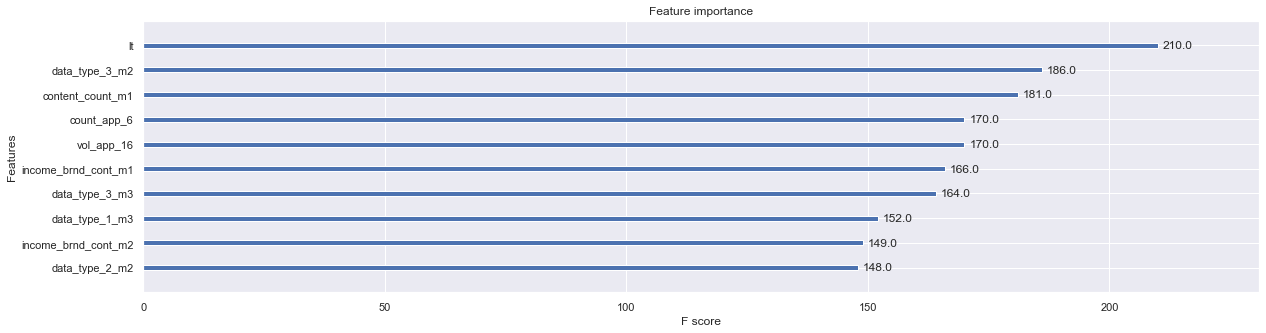

In [83]:
model = XGBClassifier(eta= 0.2, gamma= 0.3, n_estimators= 200, use_rmm= True, eval_metric='mlogloss')
model.fit(X_rous, y_rous)
ax = plot_importance(model, max_num_features=10)
fig = ax.figure
fig.set_size_inches(20, 5)